In [108]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [134]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [110]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [111]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss by MSE
    # ***************************************************
    e = y - tx @ w
    sum_e = e.T @ e

    return (0.5/len(y)) * sum_e

# 2. Grid Search

Fill in the function `grid_search()` below:

In [112]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss for each combination of w0 and w1.
    # ***************************************************
    i, k = np.indices((len(grid_w0), len(grid_w1)))
    pairs = np.column_stack((grid_w0[i.ravel()], grid_w1[k.ravel()]))

    for idx, (w0, w1) in enumerate(pairs):
        w = np.array([w0, w1])
        losses[i.ravel()[idx], k.ravel()[idx]] = compute_loss(y, tx, w)

    return losses

Let us play with the grid search demo now!

Grid Search: loss*=18.7935410195231, w0*=71.42857142857142, w1*=15.306122448979579, execution time=0.032 seconds


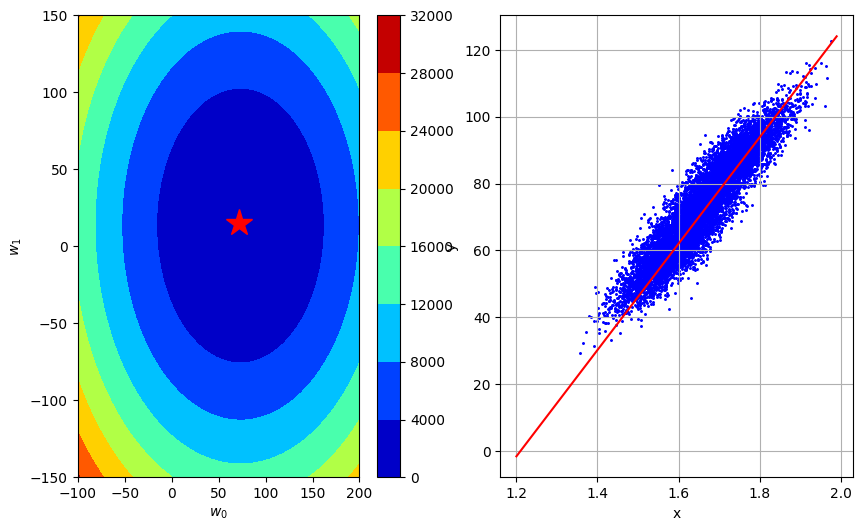

In [113]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

execution_time_lst = []
interval = [10, 50, 100, 200, 1000]
interval = [50]  # For faster execution, you can change this to [50]

for i in interval:
    # Generate the grid of parameters to be swept
    grid_w0, grid_w1 = generate_w(num_intervals=i)

    # Start the grid search
    start_time = datetime.datetime.now()
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)

    # Select the best combinaison
    loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
    end_time = datetime.datetime.now()
    execution_time = (end_time - start_time).total_seconds()

    # Print the results
    print(
        "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
            l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
        )
    )
    execution_time_lst.append(execution_time)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving
# plt.figure(figsize=(10.0, 6.0))
# plt.plot(interval, execution_time_lst, marker="o")
# plt.xlabel("Interval")
# plt.ylabel("Execution time (seconds)")
# plt.title("Execution time of Grid Search vs Interval")
# plt.show()

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [114]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute gradient vector
    # ***************************************************
    e = y - tx @ w
    gradient_w = - (tx.T @ e) / len(y)

    return gradient_w

In [115]:
w = np.array([100, 20])
print(compute_gradient(y, tx, w), np.linalg.norm(w))

w = np.array([50, 10])
print(compute_gradient(y, tx, w), np.linalg.norm(w))

[26.706078    6.52028757] 101.9803902718557
[-23.293922    -3.47971243] 50.99019513592785


Please fill in the functions `gradient_descent` below:

In [116]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters + 1 containing the model parameters as numpy arrays of shape (2, ),
            for each iteration of GD (as well as the final weights)
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute gradient and loss
        # ***************************************************
        gradient = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by gradient
        # ***************************************************
        w = w - gamma * gradient

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [135]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
gammas = [0.001, 0.01, 0.5, 1, 1.5, 2, 2.5]
# Initialization
w_initial = np.array([0, 0])

for gamma in gammas:
    print(f"Running gradient descent with gamma={gamma}")
    # Start gradient descent.
    start_time = datetime.datetime.now()
    gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()

    # Print result
    exection_time = (end_time - start_time).total_seconds()
    print("GD: execution time={t:.3f} seconds".format(t=exection_time))

Running gradient descent with gamma=0.001
GD iter. 0/49: loss=2792.236712759168, w0=0.07329392200210526, w1=0.013479712434989436
GD iter. 1/49: loss=2786.6857879602107, w0=0.14651455008220804, w1=0.026945945157543727
GD iter. 2/49: loss=2781.145959459928, w0=0.21966195753423115, w1=0.04039871164737547
GD iter. 3/49: loss=2775.617205076818, w0=0.29273621757880225, w1=0.05383802537071745
GD iter. 4/49: loss=2770.0995026737187, w0=0.36573740336332866, w1=0.06726389978033617
GD iter. 5/49: loss=2764.592830157724, w0=0.4386655879620706, w1=0.08067634831554525
GD iter. 6/49: loss=2759.09716548009, w0=0.5115208443762137, w1=0.09407538440221892
GD iter. 7/49: loss=2753.6124866361442, w0=0.5843032455339429, w1=0.10746102145280582
GD iter. 8/49: loss=2748.1387716652075, w0=0.657012864290514, w1=0.12083327286634236
GD iter. 9/49: loss=2742.675998650499, w0=0.7296497734283286, w1=0.13419215202846538
GD iter. 10/49: loss=2737.224145719046, w0=0.8022140456570054, w1=0.14753767231142623
GD iter. 11/4

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

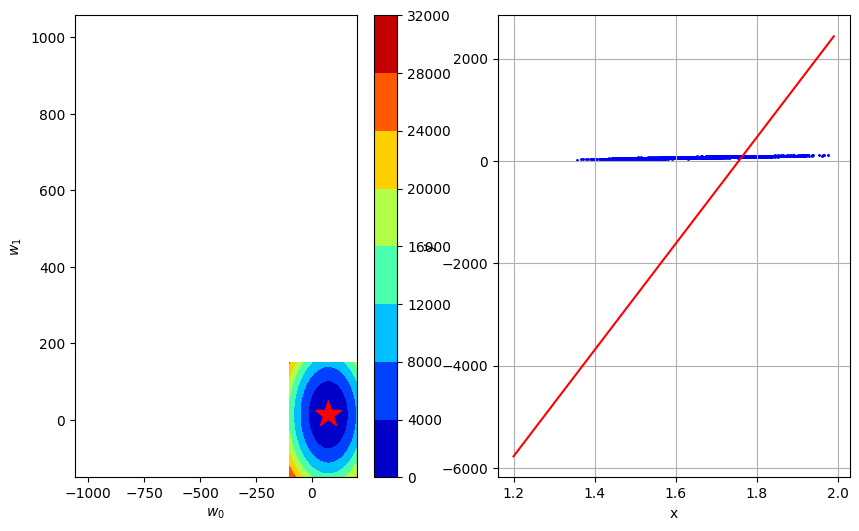

In [118]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 4. Stochastic gradient descent

In [119]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient computation. It's the same as the usual gradient.
    # ***************************************************
    return compute_gradient(y, tx, w)


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        # ***************************************************
        loss_batch = []
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size=batch_size):
            gradient = compute_stoch_gradient(minibatch_y, minibatch_tx, w)
            w = w - gamma * gradient
            loss = compute_loss(minibatch_y, minibatch_tx, w)
            loss_batch.append(loss) # compute loss for each minibatch

        loss = np.mean(loss_batch) # compute mean loss over all minibatches
        losses.append(loss)
        ws.append(w)
        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [120]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=625.8661886407749, w0=5.056073506976932, w1=-7.1548509534559575
SGD iter. 1/49: loss=1114.4647664876438, w0=15.640088187983437, w1=15.395197067972655
SGD iter. 2/49: loss=1102.604074747469, w0=21.29253327400864, w1=10.692600870660929
SGD iter. 3/49: loss=775.4797229494791, w0=25.704696806007988, w1=11.894215430445007
SGD iter. 4/49: loss=859.5422518683845, w0=30.494742213697393, w1=9.084108695398475
SGD iter. 5/49: loss=473.06240144824875, w0=33.94168779930554, w1=10.036902935403017
SGD iter. 6/49: loss=1082.6154301786323, w0=39.1393595726705, w1=8.903832084977488
SGD iter. 7/49: loss=428.1460574938087, w0=42.51266265408135, w1=6.979933715065119
SGD iter. 8/49: loss=258.23323752153345, w0=45.08100311319041, w1=5.980179176881368
SGD iter. 9/49: loss=79.26158018217875, w0=46.89007842896909, w1=3.3961046306052673
SGD iter. 10/49: loss=26.530915842252657, w0=48.00918295318894, w1=1.6298658337151093
SGD iter. 11/49: loss=406.04616072592944, w0=51.28693799500273, w1=3.44

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

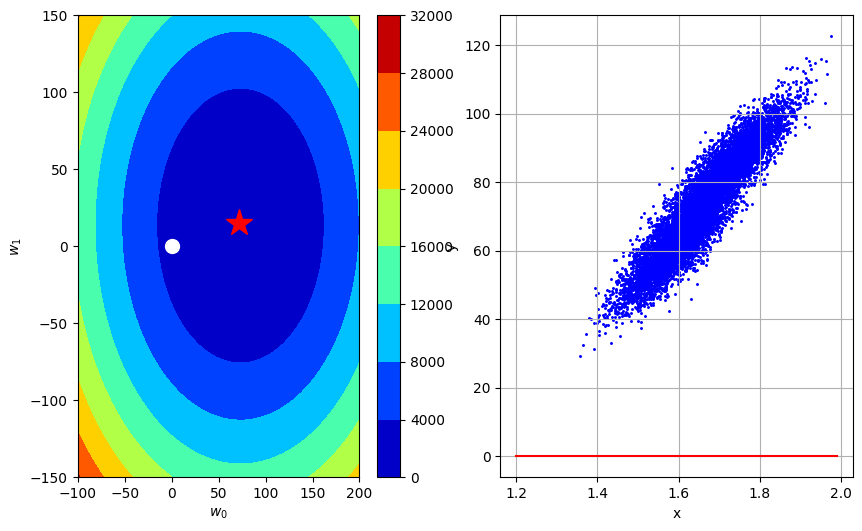

In [121]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

# 5. Effect of Outliers and MAE Cost Function

In [122]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

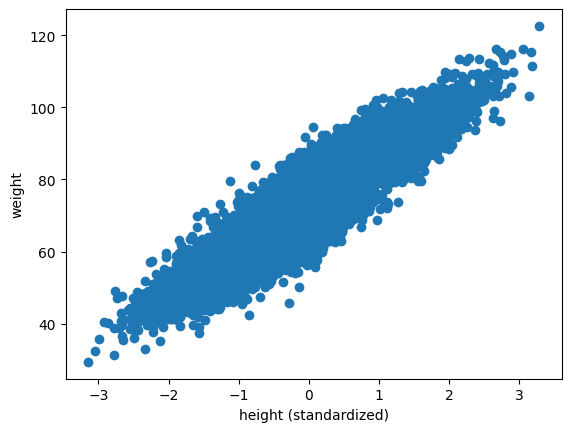

In [123]:
plt.scatter(x, y)
plt.xlabel("height (standardized)")
plt.ylabel("weight")
plt.show()

In [124]:
y.shape, tx.shape

((10000,), (10000, 2))

In [136]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
#       and the model fit
# ***************************************************
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.236712759168, w0=7.329392200210527, w1=1.3479712434989437
GD iter. 1/49: loss=2264.6350560300016, w0=13.925845180399982, w1=2.561145362647994
GD iter. 2/49: loss=1837.2777140793798, w0=19.862652862570513, w1=3.653002069882118
GD iter. 3/49: loss=1491.118267099373, w0=25.20577977652399, w1=4.635673106392836
GD iter. 4/49: loss=1210.7291150455694, w0=30.014593999082102, w1=5.5200770392524765
GD iter. 5/49: loss=983.6139018819883, w0=34.3425267993844, w1=6.316040578826147
GD iter. 6/49: loss=799.6505792194882, w0=38.237666319656476, w1=7.032407764442449
GD iter. 7/49: loss=650.6402878628629, w0=41.74329188790135, w1=7.67713823149712
GD iter. 8/49: loss=529.9419518639961, w0=44.898354899321745, w1=8.25739565184632
GD iter. 9/49: loss=432.176299704914, w0=47.73791160960009, w1=8.779627330160602
GD iter. 10/49: loss=352.9861214560576, w0=50.293512648850594, w1=9.249635840643457
GD iter. 11/49: loss=288.84207707448417, w0=52.59355358417605, w1=9.672643500078022
GD ite

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

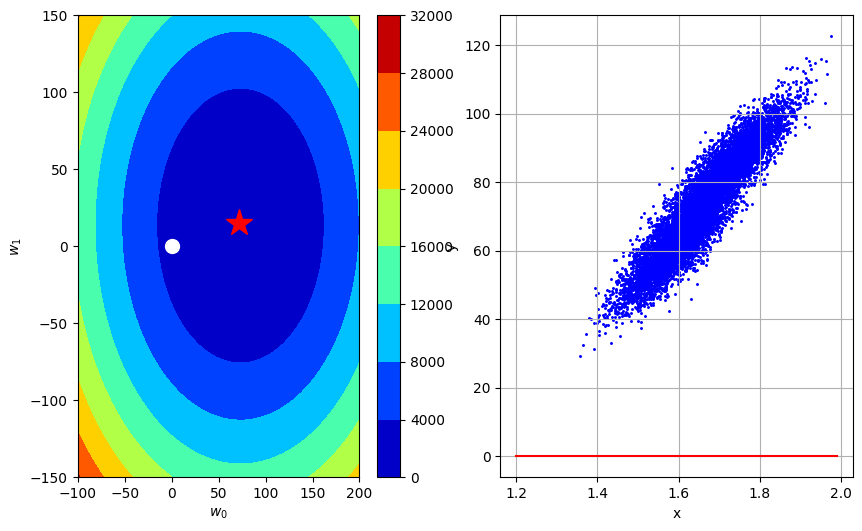

In [126]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 6. Subgradient descent

In [137]:
def compute_loss_mae(y, tx, w):
    """Calculate the loss using MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss by MAE
    # ***************************************************
    e = y - tx @ w
    sum_e = np.sum(np.abs(e))

    return (0.5/len(y)) * sum_e

In [138]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute subgradient gradient vector for MAE
    # ***************************************************
    tol = 1e-5
    e = y - tx @ w
    s = np.sign(e)
    nondiff = np.flatnonzero(np.abs(e) < tol)
    
    if nondiff.size > 0:
        # If there are non-differentiable points, we can set their sign to 0
        s[nondiff] = 0  # to avoid numerical issues with sign function

    subgradient_w = - np.sign(e) @ tx / (len(y) * 0.5)

    return subgradient_w, nondiff

In [139]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        # ***************************************************
        subgradient, ind = compute_subgradient_mae(y, tx, w)
        loss = compute_loss_mae(y, tx, w)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by subgradient
        # ***************************************************
        w = w - gamma * subgradient

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}, non-diff point = {ind}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1], ind=ind.size
            )
        )

    return losses, ws

In [140]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=36.646961001052595, w0=1.4, w1=7.318510242271259e-15, non-diff point = 0
SubGD iter. 1/499: loss=35.94696100105259, w0=2.8, w1=1.4637020484542518e-14, non-diff point = 0
SubGD iter. 2/499: loss=35.24696100105259, w0=4.199999999999999, w1=2.1955530726813775e-14, non-diff point = 0
SubGD iter. 3/499: loss=34.546961001052594, w0=5.6, w1=2.9274040969085036e-14, non-diff point = 0
SubGD iter. 4/499: loss=33.846961001052584, w0=7.0, w1=3.6592551211356296e-14, non-diff point = 0
SubGD iter. 5/499: loss=33.146961001052595, w0=8.4, w1=4.391106145362756e-14, non-diff point = 0
SubGD iter. 6/499: loss=32.44696100105259, w0=9.8, w1=5.122957169589882e-14, non-diff point = 0
SubGD iter. 7/499: loss=31.746961001052586, w0=11.200000000000001, w1=5.854808193817007e-14, non-diff point = 0
SubGD iter. 8/499: loss=31.046961001052587, w0=12.600000000000001, w1=6.586659218044133e-14, non-diff point = 0
SubGD iter. 9/499: loss=30.346961001052588, w0=14.000000000000002, w1=7.3185102422

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

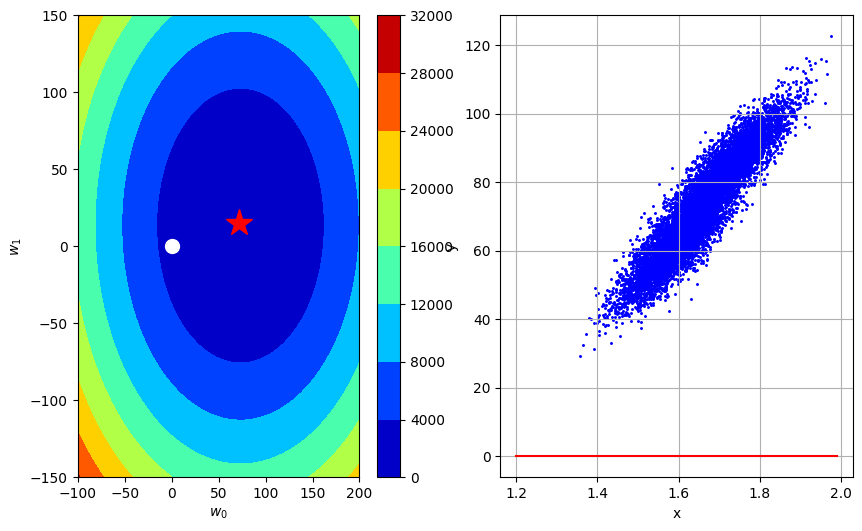

In [131]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [143]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        loss_batch = []
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size=batch_size):
            subgradient, _ = compute_subgradient_mae(minibatch_y, minibatch_tx, w)
            w = w - gamma * subgradient
            loss = compute_loss_mae(minibatch_y, minibatch_tx, w)
            loss_batch.append(loss) # compute loss for each minibatch
        loss = np.mean(loss_batch) # compute mean loss over all minibatches
        losses.append(loss)
        ws.append(w)

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [145]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=31.445872338098297, w0=0.2, w1=-0.04359918847897526
SubSGD iter. 1/499: loss=21.71870428003541, w0=0.4, w1=-0.44623133710287877
SubSGD iter. 2/499: loss=43.41429641030635, w0=0.6000000000000001, w1=-0.2212735179360468
SubSGD iter. 3/499: loss=54.346985995866525, w0=0.8, w1=0.16753878070435932
SubSGD iter. 4/499: loss=22.977481062763147, w0=1.0, w1=-0.1556734088046476
SubSGD iter. 5/499: loss=33.772214930459675, w0=1.2, w1=-0.2054914225034543
SubSGD iter. 6/499: loss=37.49637076201757, w0=1.4, w1=-0.19695633850134697
SubSGD iter. 7/499: loss=37.47316831701728, w0=1.5999999999999999, w1=-0.14067200526141055
SubSGD iter. 8/499: loss=34.09374204379646, w0=1.7999999999999998, w1=-0.059143964598687815
SubSGD iter. 9/499: loss=35.782163747922205, w0=1.9999999999999998, w1=-0.025104255090477597
SubSGD iter. 10/499: loss=27.83241111696591, w0=2.1999999999999997, w1=-0.18430017384124492
SubSGD iter. 11/499: loss=46.59083829929272, w0=2.4, w1=-0.027312228305066327
SubSGD 

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

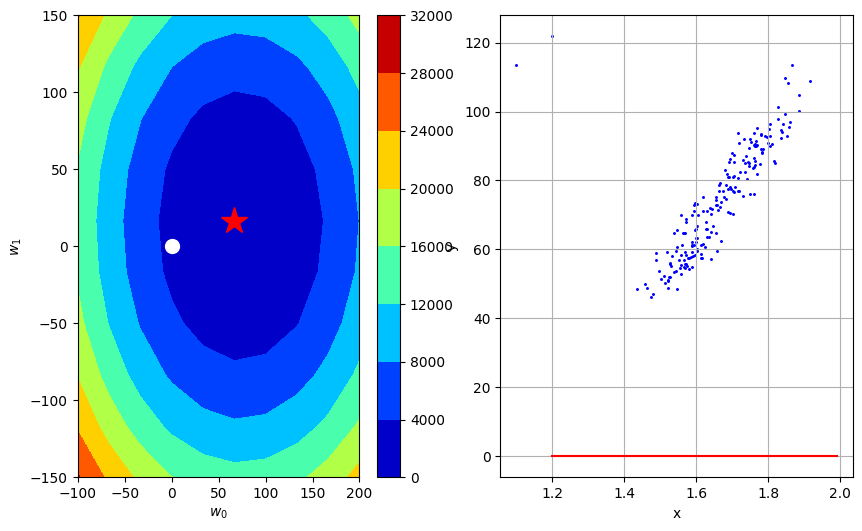

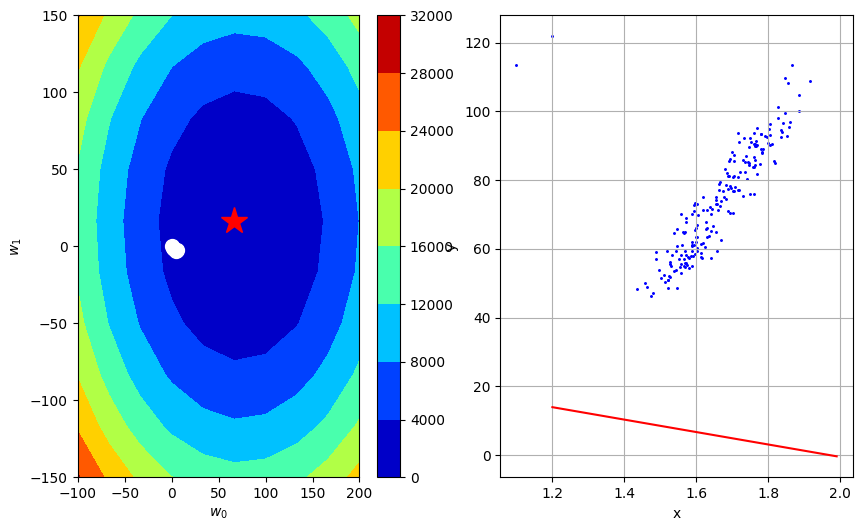

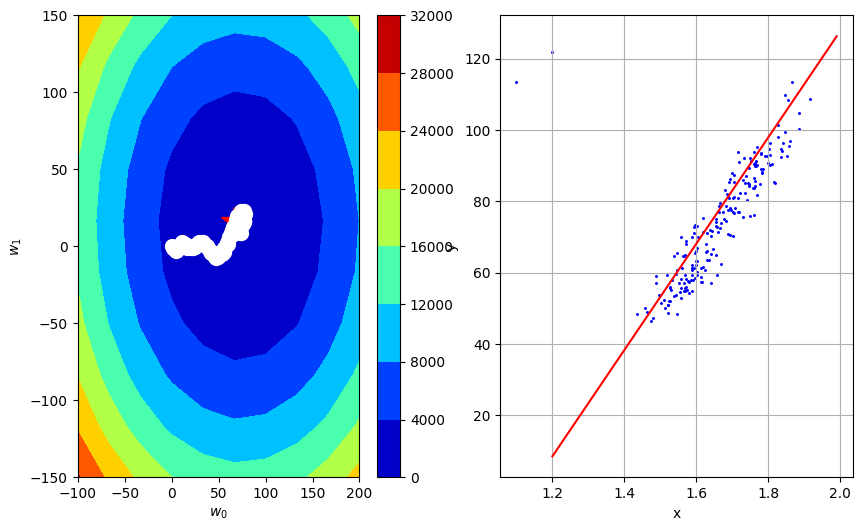

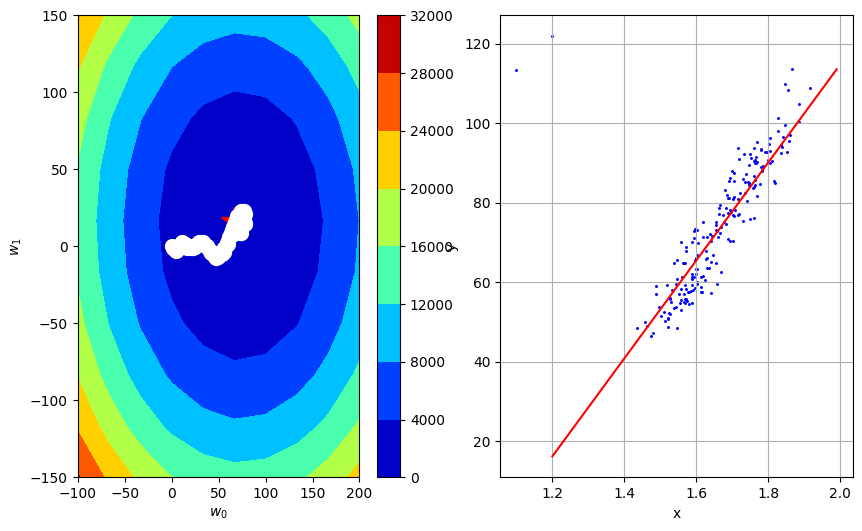

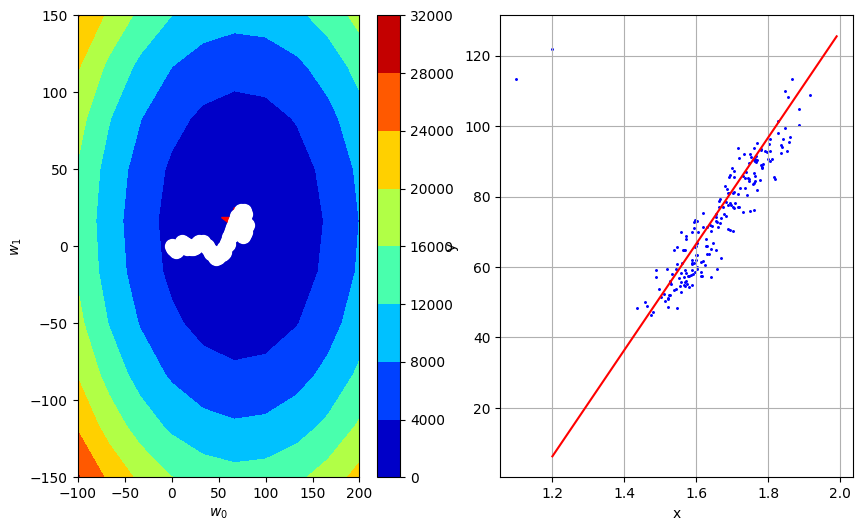

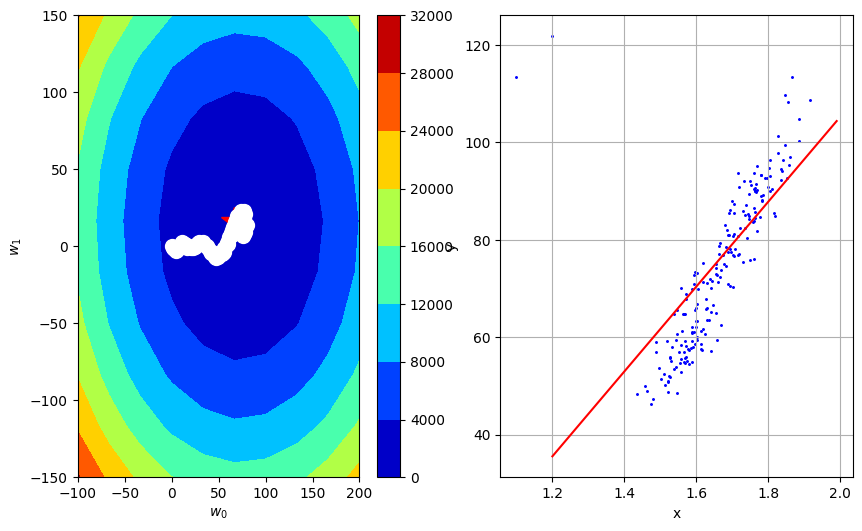

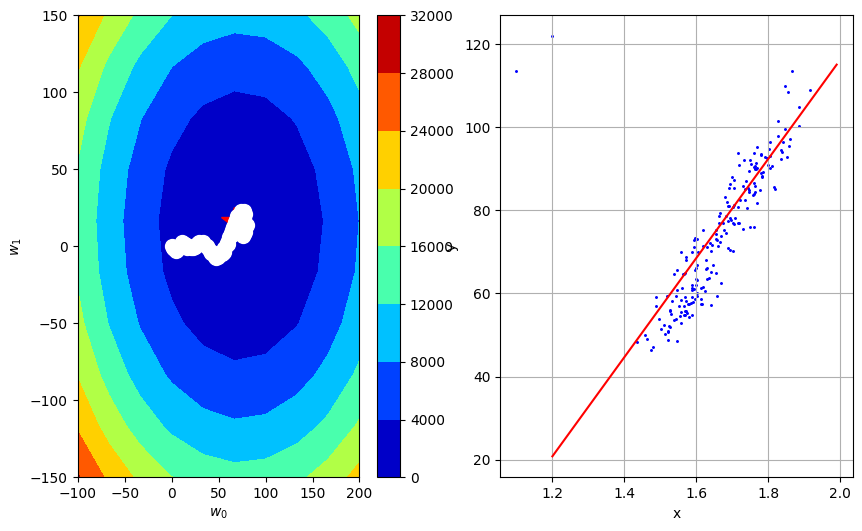

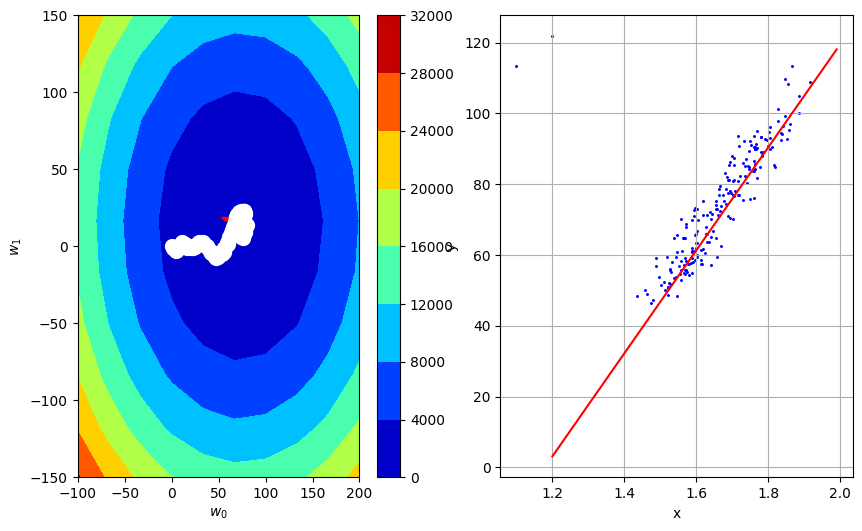

In [ ]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))